- <a href="https://www.kaggle.com/c/nbme-score-clinical-patient-notes">Ссылка</a> на соревнование KAGGLE
- <a href="https://huggingface.co/">huggingface</a>
- <a href="https://www.kaggle.com/code/yasufuminakama/nbme-deberta-base-baseline-train#tokenizer">Base notebook</a>

</hr>

Хорошая статья [How to use Autocast in PyTorch](https://wandb.ai/wandb_fc/tips/reports/How-to-use-Autocast-in-PyTorch--VmlldzoyMTk4NTky) по torch.cuda.amp.autocast(). Также ниже статьи по оптимизации работы CUDA:
- [Preventing The CUDA Out Of Memory Error In PyTorch](https://wandb.ai/wandb_fc/tips/reports/Preventing-The-CUDA-Out-Of-Memory-Error-In-PyTorch--VmlldzoxNzU3NjA1?galleryTag=general)
- [How to Use GradScaler in PyTorch](https://wandb.ai/wandb_fc/tips/reports/How-to-Use-GradScaler-in-PyTorch--VmlldzoyMTY5MDA5)

# Imports

In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import yaml
import json
import re
import os
import ast
import pprint
import logging
from tqdm.auto import tqdm
from typing import Tuple, List, Union
from dataclasses import dataclass

from transformers import BertTokenizer, AutoConfig, AutoTokenizer, AutoModel, AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Dowload the competition data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# updating the Kagggle API module using pip
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install "kaggle>=1.5.6"

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4bcf0ef99142f4795e01d0f8b8853dd04e58a0716b213a9c0200e46ab3d1a303
  Stored in directory: /root/.cache/pip/wheels/11/ec/8f/80c32ff2501f7b1a76f4df651a0242314d229a5d3e5130bd01
Successfully built kaggle


In [ ]:
%rm -rf sample_data
%mkdir -p -v NBME_-_Score_Clinical_Patient_Notes/inputs
%cd NBME_-_Score_Clinical_Patient_Notes

mkdir: created directory 'NBME_-_Score_Clinical_Patient_Notes'
mkdir: created directory 'NBME_-_Score_Clinical_Patient_Notes/inputs'
/content/NBME_-_Score_Clinical_Patient_Notes


In [ ]:
# добавляем в переменные окружения папку, в которой находится kaggle.json с токеном для kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = '//content/drive/MyDrive/kaggle'

In [ ]:
# download the competition data
!kaggle competitions download -c nbme-score-clinical-patient-notes --path . --force --quiet

In [ ]:
# unzip the competition data
!unzip -qq nbme-score-clinical-patient-notes.zip -d inputs

# Let's have a look at our data

In [ ]:
%ls -l //content/NBME_-_Score_Clinical_Patient_Notes/inputs

total 34908
-rw-r--r-- 1 root root     4354 Jan 10  2022 features.csv
-rw-r--r-- 1 root root 34966100 Jan 10  2022 patient_notes.csv
-rw-r--r-- 1 root root       93 Jan 10  2022 sample_submission.csv
-rw-r--r-- 1 root root      141 Jan 10  2022 test.csv
-rw-r--r-- 1 root root   761246 Jan 10  2022 train.csv


### features.csv

In [ ]:
features = pd.read_csv('//content/NBME_-_Score_Clinical_Patient_Notes/inputs/features.csv')
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [ ]:
features.nunique()

feature_num     143
case_num         10
feature_text    131
dtype: int64

In [ ]:
features.isna().sum()

feature_num     0
case_num        0
feature_text    0
dtype: int64

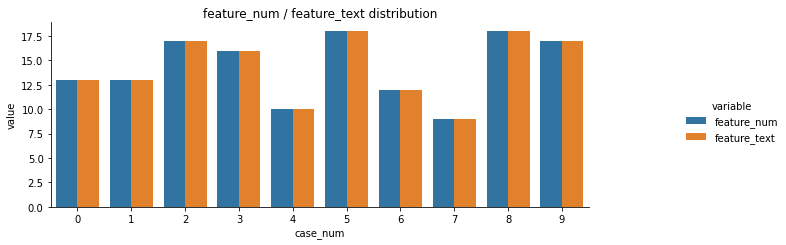

In [ ]:
grouped = features.groupby('case_num').count()
grouped = pd.melt(grouped, ignore_index=False).reset_index()

fig = sns.catplot(x='case_num', y='value', data=grouped, hue='variable', kind='bar')
fig.fig.set_figwidth(12)
fig.fig.set_figheight(3)
plt.title('feature_num / feature_text distribution')
plt.show()

`feature_num` по сути является уникальным ID значением, соответствующим уникальной паре `feature_text` / `case_num`. В колонке `feature_text` есть повторения. 

In [ ]:
print('Количество повторений пары case_num / feature_text: {}'.format(len(features[features.duplicated(subset=['case_num', 'feature_text'])])))

Количество повторений пары case_num / feature_text: 0


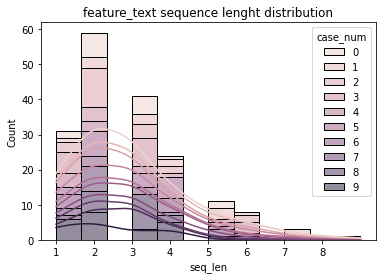

In [ ]:
features['feature_text_splited'] = features['feature_text'].apply(lambda seq: re.split('-or-', seq, flags=re.IGNORECASE))
features = features.explode('feature_text_splited', ignore_index=True)
features['seq_len'] = features['feature_text_splited'].apply(lambda seq: len(seq.split('-')))

sns.histplot(data=features, x='seq_len', hue='case_num', kde=True, multiple="stack")
plt.xticks(ticks=np.arange(features['seq_len'].min(), features['seq_len'].max()))
plt.title('feature_text sequence lenght distribution')
plt.show()

При этом интересно отметить, что $ \text{feature_num} // 100 = \text{case_num} $. Т.е. первая цифра в `feature_num` является `case_num` (кроме случая `case_num` == 0, в этом случае просто размерность понижается). Остальные числа идут по порядку.

In [ ]:
print('Первая цифра - case_num:\t{}'.format(np.all(features.groupby('case_num') \
                                    .apply(lambda group: group.feature_num // 100 == group.case_num).values)))
print('Остальные по порядку:\t\t{}'.format(np.all(features.groupby('case_num') \
                                   .apply(lambda group: (group.feature_num % 100).max() == group.feature_num.nunique() - 1).values)))

Первая цифра - case_num:	True
Остальные по порядку:		True


### patient_notes.csv

In [ ]:
patient_notes = pd.read_csv('//content/NBME_-_Score_Clinical_Patient_Notes/inputs/patient_notes.csv')
patient_notes.info()
patient_notes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [ ]:
patient_notes.nunique()

pn_num        42146
case_num         10
pn_history    42146
dtype: int64

In [ ]:
patient_notes.isna().sum()

pn_num        0
case_num      0
pn_history    0
dtype: int64

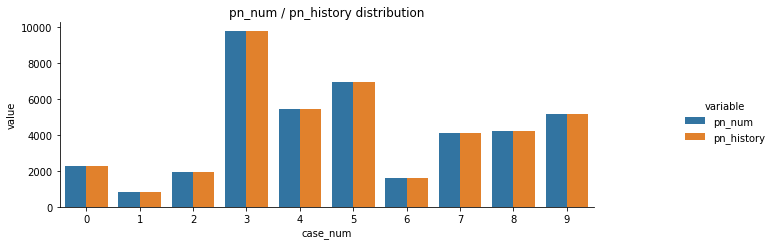

In [ ]:
grouped = patient_notes.groupby('case_num').count()
grouped = pd.melt(grouped, ignore_index=False).reset_index()

fig = sns.catplot(x='case_num', y='value', data=grouped, hue='variable', kind='bar')
fig.fig.set_figwidth(12)
fig.fig.set_figheight(3)
plt.title('pn_num / pn_history distribution')
plt.show()

`pn_num` является уникальным ID для каждой конкретной `pn_history`

In [ ]:
# Пример pn_history
print(patient_notes[patient_notes.pn_num == 16].pn_history.iloc[0])

HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. 
PMHx: none
Rx: uses friends adderrall
FHx: mom with "thyroid disease," dad with recent heart attcak
All: none
Immunizations: up to date
SHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms


При этом интересно отметить, что $ \text{pn_num} // 10000 = \text{case_num} $. Т.е. первая цифра в `pn_num` является `case_num` (кроме случая `case_num` == 0, в этом случае просто размерность понижается). Остальные числа НЕ идут по порядку.

In [ ]:
print('Первая цифра - case_num:\t{}'.format(np.all(patient_notes.groupby('case_num') \
                                    .apply(lambda group: group.pn_num // 10000 == group.case_num).values)))
print('Остальные по порядку:\t\t{}'.format(np.all(patient_notes.groupby('case_num') \
                                   .apply(lambda group: (group.pn_num % 10000).max() == group.pn_num.nunique() - 1).values)))

Первая цифра - case_num:	True
Остальные по порядку:		False


In [ ]:
# пример
test = patient_notes.copy()
test['id'] = test['pn_num'] % 10000
test['row_num'] = test.groupby('case_num').cumcount()
test[test.case_num == 1].head()
# число 10003 пропущено. С чем это связано - непонятно

,pn_num,case_num,pn_history,id,row_num
2268,10000,1,Ms. Suzanne Powelton is a 20 y/o F that presen...,0,0
2269,10001,1,Suzanne Powelton is a 20 year old woman who pr...,1,1
2270,10002,1,HPI: 20 yo f c/o constant worsening right lowe...,2,2
2271,10004,1,20 y/o F c/o abdominal pain \r\n5/10. from la...,4,3
2272,10005,1,20 YO F came to the ED complaining of Right lo...,5,4


### sample_submission.csv

In [ ]:
sample_submission = pd.read_csv('//content/NBME_-_Score_Clinical_Patient_Notes/inputs/sample_submission.csv')
sample_submission.info()
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5 non-null      object
 1   location  3 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes


,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


### train.csv

In [ ]:
train = pd.read_csv('//content/NBME_-_Score_Clinical_Patient_Notes/inputs/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)
train = train.explode(['annotation', 'location'])
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16633 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           16633 non-null  object
 1   case_num     16633 non-null  int64 
 2   pn_num       16633 non-null  int64 
 3   feature_num  16633 non-null  int64 
 4   annotation   12234 non-null  object
 5   location     12234 non-null  object
dtypes: int64(3), object(3)
memory usage: 909.6+ KB


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,dad with recent heart attcak,696 724
1,00016_001,0,16,1,"mom with ""thyroid disease",668 693
2,00016_002,0,16,2,chest pressure,203 217
3,00016_003,0,16,3,intermittent episodes,70 91
3,00016_003,0,16,3,episode,176 183


In [ ]:
train[['id', 'case_num', 'pn_num', 'feature_num']].nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
dtype: int64

In [ ]:
# nan values появились в колонках annotation и location после операции explde, 
# т.к. в некоторых случаях вв них были пустые листы - экзаминуемый не обозначил features в patient note
train.isna().sum()

id                0
case_num          0
pn_num            0
feature_num       0
annotation     4399
location       4399
dtype: int64

In [ ]:
# для каждого из 10-ти case_num представлено в обучающей выборке по 100 pn_num
train.groupby('case_num')['pn_num'].nunique()

case_num
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: pn_num, dtype: int64

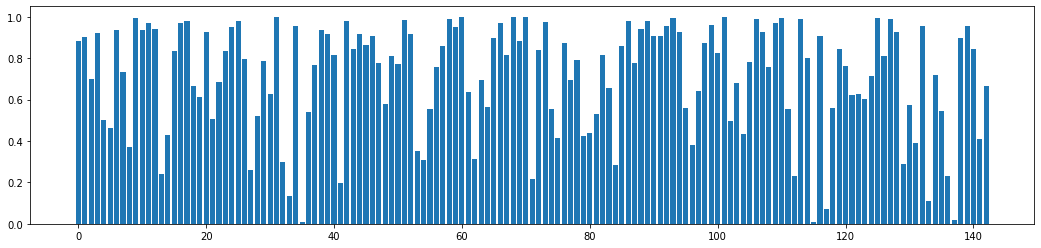

In [ ]:
grouped = train.groupby(['feature_num'])[['pn_num', 'annotation']].count()
grouped.rename({'annotation': 'annotation_count', 'pn_num': 'pn_num_count'}, axis=1, inplace=True)
grouped['share'] = grouped.annotation_count / grouped.pn_num_count
grouped.reset_index(inplace=True)
grouped = grouped.sort_values(by='feature_num', ascending=True, ignore_index=True)
grouped['feature_id'] = np.arange(len(grouped))

plt.figure(figsize=(18, 4))
plt.bar(x=grouped.feature_id, height=grouped.share)
plt.show()

Видим, что есть такие признаки, которые практически не были отражены в patient notes экзаминуемыми (во всяком случае в тестовой выборке). К примеру `feature_num` 807 и 209 были отмечены по одному разу только двумя экзаминуемыми

In [ ]:
grouped.sort_values(by='share', ascending=True).merge(features[['feature_num', 'feature_text']], how='left', on='feature_num').head()

,feature_num,pn_num_count,annotation_count,share,feature_id,feature_text
0,807,100,1,0.01,115,Hallucinations-after-taking-Ambien
1,209,100,1,0.01,35,Stress
2,911,100,2,0.02,137,Meningococcal-vaccine-status-unknown
3,809,100,7,0.07,117,Unsuccessful-napping
4,907,100,11,0.11,133,No-rash


In [ ]:
# интересно, что некоторые испытуемые отметили наличие галюцинаций, но связали их с приемом Ambien
# в некоторых случаях галюцинации обозначали через сокращение - AVH
# в некоторых случаях записывалось что пациент видел что-то, но галюцинациями это не называлось
i = 0
for pn_history in patient_notes[patient_notes.case_num.isin(features[features.feature_num == 807]['case_num'].values)]['pn_history'].values:
  print(re.findall(pattern=re.compile('(hallu[\w]*)|(avh)', flags=re.IGNORECASE), string=pn_history))
  if i > 5:
    break
  print('-' * 100)
  i += 1

[('hallucinations', '')]
----------------------------------------------------------------------------------------------------
[('Hallucinations', '')]
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------
[('hallucinations', '')]
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------
[('', 'AVH')]


In [ ]:
# колонка id представляет из себя ничто иное, как {pn_num}_{feature_num}
assert train['id'].apply(lambda id: int(id.split('_')[0])).equals(train['pn_num'])
assert train['id'].apply(lambda id: int(id.split('_')[1])).equals(train['feature_num'])

Объединим таблицу `train` с таблицами `features` и `patient_notes`

In [ ]:
train_joined = train.merge(features, how='left', on=['case_num', 'feature_num'])
train_joined = train_joined.merge(patient_notes, how='left', on=['case_num', 'pn_num'])
train_joined.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,feature_text_splited,seq_len,pn_history
0,00016_000,0,16,0,dad with recent heart attcak,696 724,Family-history-of-MI-OR-Family-history-of-myoc...,Family-history-of-MI,4,HPI: 17yo M presents with palpitations. Patien...
1,00016_000,0,16,0,dad with recent heart attcak,696 724,Family-history-of-MI-OR-Family-history-of-myoc...,Family-history-of-myocardial-infarction,5,HPI: 17yo M presents with palpitations. Patien...
2,00016_001,0,16,1,"mom with ""thyroid disease",668 693,Family-history-of-thyroid-disorder,Family-history-of-thyroid-disorder,5,HPI: 17yo M presents with palpitations. Patien...
3,00016_002,0,16,2,chest pressure,203 217,Chest-pressure,Chest-pressure,2,HPI: 17yo M presents with palpitations. Patien...
4,00016_003,0,16,3,intermittent episodes,70 91,Intermittent-symptoms,Intermittent-symptoms,2,HPI: 17yo M presents with palpitations. Patien...


### test.csv

In [ ]:
test = pd.read_csv('//content/NBME_-_Score_Clinical_Patient_Notes/inputs/test.csv')
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5 non-null      object
 1   case_num     5 non-null      int64 
 2   pn_num       5 non-null      int64 
 3   feature_num  5 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 288.0+ bytes


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


### Выводы

Имеется следующие таблицы:
1. `features.csv` - для каждого клинического случая (всего в соревновании 10-ть клинических случая) имеется некое множество признаков, которые характеризуют соответствующий клинический случай. Эти множества могут пересекаться, т.е. один и тот же признак присутствует в наборе признаков для разных клинических случаев (при этом ID признака в этих наборах - `feature_num` - различный). К примеру, признак `Feemale` или `Male` встречается в наборах признаков для разных клинических случаев.
  1. `feature_num` - ID уникальной пары `case_num` / `feature_text`. Всего 143 уникальных значений (не по порядку). На самом деле в номере `feature_num` содержится информация о `case_num`: $$ \text{feature_num} // 100 = \text{case_num} $$
  2. `case_num` - ID клинического случая. В соревновании всего 10-ть клинических случаев (уникальных значений `case_num` - [0, 9])
  3. `feature_text` - текстовое описание признака. Есть повторения, т.к. один и тот же признак может характеризовать разные клинические случаи. Один и тот же признак может быть по разному описан. Для разделения различных описаний одного и того же признака в исходных данных используется `-OR-` или `-or-`. Отдельные слова в описании признака разделены `-` без пробелов.

2. `patient_notes.csv` - набор "конспектов", сделанных тестируемыми
  1. `pn_num` - уникальный ID "конспекта". Всего 42146 уникальных значений (не по порядку). На самом деле в номере `pn_num` содержится информация о `case_num`: $$ \text{pn_num} // 10000 = \text{case_num} $$
  2. `case_num` - ID клинического случая
  3. `pn_history` - текст "конспекта"

3. `train.csv` - таблица с тренировочными данными
4. `test.csv` - пример с тестовыми данными, содержащий всего 5 строк

# Baseline (DeBERTa)

### Tutorial

#### Tokenize

Проработано <a href="https://huggingface.co/docs/transformers/preprocessing">отсюда</a>

In [ ]:
# загружаем предобученый tokenizer (Bert base)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# возьмем в качестве примера следующее предложение:
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"

# преобразуем данное предложение
encoded_input = tokenizer(sequence_a, sequence_b)
pprint.pprint(encoded_input, width=110, compact=True)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102, 2777, 1110, 20164, 10932, 2271,
               7954, 1359, 136, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Мы получили словарь с тремя важными элементами:
- `input_ids` - индексы (номера) в словаре, соответствующие каждому токену.
- `token_type_ids` - указывает, к какому предложению принадлежит токен, если более нескольких предложений. При этом следует обратить внимание на то, что в случае с DeBert tokenizer обе последовательности будут иметь значения [0, 0, 0, 0, 0, 0 ... 0, 0], т.к. данная модель не обучалась на сочетаниях двух предложений.
- `attention_mask` - маска, характеризующая использования механизма внимания к данному токену.

In [ ]:
# теперь сделаем обратное преобразование - из набора ID слов получим декодированные предложения.
decoded = tokenizer.decode(encoded_input["input_ids"])
print(decoded)

[CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]


In [ ]:
# А что, если передать токенайзеру батч последовательностей?
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences)
pprint.pprint(encoded_input, width=110, compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1]],
 'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102],
               [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102],
               [101, 1327, 1164, 5450, 23434, 136, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0]]}


In [ ]:
# вывести весь доступный словарь слов
# это словарь, по ключу можно получить индекс слова в словаре
vocab = tokenizer.get_vocab()
print('Размер словаря: {}'.format(len(vocab)))
print('ID слова {}: {}'.format('world', vocab['world']))

Размер словаря: 28996
ID слова world: 1362


In [ ]:
# если нужно получить только набор ID из словаря, то достаточно воспользоваться методом encode
sequence = "Hello, world"
encoded_sequence = tokenizer.encode(sequence)
decoded_sequence = tokenizer.decode(encoded_sequence)
print(encoded_sequence)
print(decoded_sequence)

[101, 8667, 117, 1362, 102]
[CLS] Hello, world [SEP]


In [ ]:
# можно отключить добавление special tokens
sequence = "Hello, world"
encoded_sequence = tokenizer.encode(sequence, add_special_tokens=False)
decoded_sequence = tokenizer.decode(encoded_sequence)
print(encoded_sequence)
print(decoded_sequence)

[8667, 117, 1362]
Hello, world


#### Pad

In [ ]:
# при передаче батча с предложениями, они в должны быть одинаковой длины. Это достигается путем добавления 
# 0 в конце предложений (padding=True). Обратите внимение, что и у attention mask появились 0.
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True)
pprint.pprint(encoded_input, width=110, compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
 'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0],
               [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102],
               [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [ ]:
tokenizer.decode(encoded_input.get('input_ids')[0])

'[CLS] But what about second breakfast? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

`padding` controls the padding. It can be a boolean or a string which should be:

- `True` or `'longest'` to pad to the longest sequence in the batch (doing no padding if you only provide a single sequence).

- `'max_length'` to pad to a length specified by the max_length argument or the maximum length accepted by the model if no max_length is provided (`max_length=None`). If you only provide a single sequence, padding will still be applied to it.

- `False` or `'do_not_pad'` to not pad the sequences. As we have seen before, this is the default behavior.

In [ ]:
print('Узнать максимальную длину последовательности для модели: {}'.format(AutoConfig.from_pretrained('bert-base-cased').max_position_embeddings))

Узнать максимальную длину последовательности для модели: 512


#### Truncation

In [ ]:
# иногда предложение слишком длинное для успешного обучения модели. В таком случае
# целесообразно "обрезать" такие предложения по количеству токенов (truncation=True).
# Урезание последовательности в данном случае идет по  максимально возможной длины
# последовательности для языковой модели.
print(f'Максимальное количество токенов в предложении: {tokenizer.max_len_single_sentence}')
print(f'Максимальное количество токенов в последовательности из двух предложений '
      f'(при подходе c обучением на двух предложениях): {tokenizer.max_len_sentences_pair}')

Максимальное количество токенов в предложении: 510
Максимальное количество токенов в последовательности из двух предложений (при подходе c обучением на двух предложениях): 509


Вообще, максимальная длина последовательности токенов для языковой модели BERT - 512. Но мы видим, что значение `max_len_single_sentence` равно 510. Это связано с тем, что в последовательность токенов добавляются еще 2 - в начало и конец. В итоге последовательность токенов будет выглядеть следующим образом:

`[CLS] [последовательность токенов предложения] [SEP]`

В случае с обучением с двумя предложениями, в середину между предложениями добавляется еще один токен (поэтому 509): 

`[CLS] [последовательность 1] [SEP] [последовательность 1] [SEP]`

In [ ]:
over_length_sequence = ['sequence'] * 511
print(f'Длина предложения: {len(over_length_sequence)}')
over_length_sequence = ' '.join(over_length_sequence)
encoded_input = tokenizer(over_length_sequence, truncation=False)
encoded_input_trunc = tokenizer(over_length_sequence, truncation=True)
print(f"Длина последовательности с truncation=False: {len(encoded_input.get('input_ids'))}")
print(f"Длина последовательности с truncation=True: {len(encoded_input_trunc.get('input_ids'))}")

Длина предложения: 511
Длина последовательности с truncation=False: 513
Длина последовательности с truncation=True: 512


`truncation` controls the truncation. It can be a boolean or a string which should be:

- `True` or `'only_first'` truncate to a maximum length specified by the `max_length` argument or the maximum length accepted by the model if no `max_length` is provided (`max_length=None`). This will only truncate the first sentence of a pair if a pair of sequence (or a batch of pairs of sequences) is provided.

- `'only_second'` truncate to a maximum length specified by the `max_length` argument or the maximum length accepted by the model if no max_length is provided (`max_length=None`). This will only truncate the second sentence of a pair if a pair of sequence (or a batch of pairs of sequences) is provided.

- `'longest_first'` truncate to a maximum length specified by the `max_length` argument or the maximum length accepted by the model if no max_length is provided (`max_length=None`). This will truncate token by token, removing a token from the longest sequence in the pair until the proper length is reached.

- `False` or `'do_not_truncate'` to not truncate the sequences. As we have seen before, this is the default behavior.

#### Build tensors

In [ ]:
# в конце концов для преобразования набора токенов в тензор (для подачи на вход модели), 
# можно воспользоваться атрибутом return_tensors, принимающим значения 'pt' для Pytorh
# и 'tf' для TensorFlow
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input.get('input_ids'))

tensor([[  101,  1252,  1184,  1164,  1248,  6462,   136,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1790,   112,   189,  1341,  1119,  3520,  1164,  1248,  6462,
           117, 21902,  1643,   119,   102],
        [  101,  1327,  1164,  5450, 23434,   136,   102,     0,     0,     0,
             0,     0,     0,     0,     0]])


## Configuration

In [ ]:
if not os.path.isdir('nmbe_model'):
  os.mkdir('nmbe_model')

# создаем файлик __init__.py для создания модуля nmbe_model
with open('nmbe_model/__init__.py', 'w') as file:...

In [ ]:
%%writefile nmbe_model/config.yaml
model:
  checkpoint: "microsoft/deberta-base"
  fc_dropout: 0.2
  use_pretrained: True
  config_path:
data:
  max_length: 466
train:
  device: "cuda"
  batch_size: 12
  n_folds: 5
  n_workers: 4
  backbone_lr: 2E-5
  fc_lr: 2e-5
  weight_decay: 0.01
  betas: [0.9, 0.999]
  eps: 1e-8
  scheduler_type: "linear"
  num_warmup_steps: 0
  num_cycles: 0.5

Writing nmbe_model/config.yaml


In [ ]:
def read_yaml(file_path: str) -> dict:
  """
  Функция для считывания config файла.
  :param file_path: путь к config файлу.
  :return: параметры из config файла.
  """

  with open(file_path, 'r') as f:
    try:
      loader = yaml.SafeLoader

      # добавляем возможность считывать числа, записанные в YAML файл в формате 1e-4, к примеру
      loader.add_implicit_resolver(
          u'tag:yaml.org,2002:float',
          re.compile(u'''^(?:
                         [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
                         |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
                         |\\.[0-9_]+(?:[eE][-+][0-9]+)?
                         |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
                         |[-+]?\\.(?:inf|Inf|INF)
                         |\\.(?:nan|NaN|NAN))$''', re.X),
          list(u'-+0123456789.')
      )

      return yaml.load(f, Loader=loader)
    except yaml.YAMLError as exc:
      print(exc)


@dataclass
class ModelConfig:
  checkpoint: str = "microsoft/deberta-base"
  fc_dropout: Union[int, float] = 0.2
  use_pretrained: bool = True
  config_path: str = None


@dataclass
class DataConfig:
  max_length: int = 512


@dataclass
class TrainConfig:
  device: str = "cuda"
  batch_size: int = 12
  n_folds: int = 5
  n_workers: int = 4
  backbone_lr: Union[int, float] = 2e-5
  fc_lr: Union[int, float] = 2e-5
  weight_decay: Union[int, float] = 0.01
  betas: Tuple[Union[int, float], Union[int, float]] = (0.9, 0.999)
  eps: Union[int, float] = 1e-8
  scheduler_type: str = "linear"
  num_warmup_steps: int = 0
  num_cycles: Union[int, float] = 0.5

In [ ]:
model_cfg = ModelConfig(**read_yaml(file_path="nmbe_model/config.yaml").get("model"))
data_cfg = DataConfig(**read_yaml(file_path="nmbe_model/config.yaml").get("data"))
train_cfg = TrainConfig(**read_yaml(file_path="nmbe_model/config.yaml").get("train"))

print(model_cfg)
print(data_cfg)
print(train_cfg)

ModelConfig(checkpoint='microsoft/deberta-base', fc_dropout=0.2, use_pretrained=True, config_path=None)
DataConfig(max_length=466)
TrainConfig(device='cuda', batch_size=12, n_folds=5, n_workers=4, backbone_lr=2e-05, fc_lr=2e-05, weight_decay=0.01, betas=[0.9, 0.999], eps=1e-08, scheduler_type='linear', num_warmup_steps=0, num_cycles=0.5)


## Data loading

In [ ]:
# train
train = pd.read_csv('inputs/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)

# features
features = pd.read_csv('inputs/features.csv')

# patient_notes
patient_notes = pd.read_csv('inputs/patient_notes.csv')

display(train.head())
print('train.shape:', train.shape, '\n')
display(features.head())
print('features.shape:', features.shape, '\n')
display(patient_notes.head())
print('patient_notes.shape:', patient_notes.shape)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724]
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693]
2,00016_002,0,16,2,[chest pressure],[203 217]
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]"
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258]


train.shape: (14300, 6) 



,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


features.shape: (143, 3) 



,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


patient_notes.shape: (42146, 3)


In [ ]:
# join the data
train_joined = train.merge(features, how='left', on=['feature_num', 'case_num'])
train_joined = train_joined.merge(patient_notes, how='left', on=['pn_num', 'case_num'])
train_joined.head()

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...


## Loading tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_cfg.checkpoint)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

## Max length calculation

Определение максимальной длины последовательности.

In [ ]:
def calculate_sequence_length(input_sequences: list, tokenizer, add_special_tokens: bool = False) -> int:
  """
  Данная функция определяет длину максимальной последовательности из токенов.
  :param input_sequences: list с последовательностями (например с предложениями)
  :param tokenizer: используемый tokenizer для кодировки последовательности
  :param add_special_tokens: True, если необходимо добавлять специальные токены [CLS], [SEP] или другие
  :return: длина максимальной последовательности из токенов
  """
  max_sequence_length = 0
  for curr_sequence in tqdm(input_sequences):
    curr_sequence_encoded = tokenizer(curr_sequence, add_special_tokens=add_special_tokens)
    max_sequence_length = max(max_sequence_length, len(curr_sequence_encoded.get('input_ids')))
  return max_sequence_length


# максимальная длина последовательности feature_text
feature_text_values = features['feature_text'].values
feature_text_max_sequence_length = calculate_sequence_length(input_sequences=feature_text_values, tokenizer=tokenizer)
print('Максимальная длина последовательности feature_text: {}'.format(feature_text_max_sequence_length))

# максимальная длина последовательности pn_history
pn_history_values = patient_notes['pn_history'].values
pn_history_max_sequence_length = calculate_sequence_length(input_sequences=pn_history_values, tokenizer=tokenizer)
print('Максимальная длина последовательности pn_history: {}'.format(pn_history_max_sequence_length))

# суммарная максимальная длина последовательности [CLS] max{feature_text} [SEP] max{pn_history} [SEP]
total_max_sequence_length = feature_text_max_sequence_length + pn_history_max_sequence_length + 3
print('Суммарная максимальная длина последовательности: {}'.format(total_max_sequence_length))

  0%|          | 0/143 [00:00<?, ?it/s]

Максимальная длина последовательности feature_text: 30


  0%|          | 0/42146 [00:00<?, ?it/s]

Максимальная длина последовательности pn_history: 433
Суммарная максимальная длина последовательности: 466


## Custom dataset

В данном разделе написан класс CustomDataset. Экземпляр инициализируется с параметрами:
1. tokenizer - токенизатор, преобразующий последовательность в набор токенов (см. раздел Loading tokenizer).

К примеру:

```python
sequence_1 = "Dad with recent heart attack."
sequence_2 = "Family history of myocardial infarction"

encoded_sequence = tokenizer(
  sequence_1, sequence_2, add_special_tokens=True, max_length=20, padding="max_length", return_offsets_mapping=False)
print(encoded_sequence)
```
Output:
```python
{
    'input_ids': [1, 39253, 19, 485, 1144, 908, 4, 2, 27818, 750, 9, 127, 43682, 2617, 4047, 271, 14970, 2, 0, 0],
    'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
}
```
Где
- `input_ids` - набор закодированных токенов. Причем 0, 1, 2 в данной последовательности - специальные токены - [CLS], [SEP], [PAD] соответственно (классификация, разделитель двух последовательностей sequence_1 и sequence_2, паддинг - увеличивает последовательность токенов до необходимой длины указанной в `max_length`).
- `token_type_ids` - маска последовательностей (нули - токены первой последовательности + padding, 1 - токены второй последовательности).
- `attention_mask` - маска токенов (1 - токен, 0 - padding).

Декодируем полученные токены:

```python
tokenizer.decode(encoded_sequence.get("input_ids"))
```
Output:
```python
[CLS]Dad with recent heart attack.[SEP]Family history of myocardial infarction[SEP][PAD][PAD]
```

2. feature_texts - фичи болезни, которые необходимо найти в заметках (patient_notes), np.ndarray.

3. pn_histories - заметки, записанные со слов пациента, np.ndarray.

4. locations - дипазоны символов в заметках, соответствующих указанной фиче болезни, np.ndarray.

5. max_length - максимальная длина последовательности токенов.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, feature_texts: np.ndarray, pn_histories: np.ndarray, locations: np.ndarray, 
                 max_length: int = 512):
        self.tokenizer = tokenizer
        self.feature_texts = feature_texts
        self.pn_histories = pn_histories
        self.locations = locations
        self.max_length = max_length

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, idx: int):
        def prepare_input(curr_pn_history: str, curr_feature_text: str):
            """
            Функция предназначена для кодирования пары curr_pn_history, curr_feature_text
            :param curr_pn_history: текущая pn_history
            :param curr_feature_text: текущий feature_text
            :return: encoded - словарь {'input_ids': torch.tensor, 'token_type_ids': torch.tensor,
            'attention_mask': torch.tensor}
            """
            encoded = self.tokenizer(curr_pn_history, curr_feature_text, add_special_tokens=True,
                                     max_length=self.max_length, padding="max_length", return_offsets_mapping=False)
            return {k: torch.tensor(v, dtype=torch.long) for k, v in encoded.items()}

        def prepare_label(curr_pn_history: str, curr_location: list):
            """
            Функция предназначена для получения labels из pn_history и аннотаций.
            :param curr_pn_history: текущая pn_history
            :param curr_location: текущая разметка аннотаций
            :return: labels - разметка токенов, где значения
              -1 - не относящиеся к pn_history токены ([CLS], [SEP], [PAD])
              0 - относящиеся к pn_history токены, но не относящиеся к аннотациям
              1 - токены, относящиеся как и к pn_history, так и к аннотациям
            """
            # кодируем текущий pn_history
            encoded = self.tokenizer(curr_pn_history, add_special_tokens=True, max_length=self.max_length, 
                                     padding='max_length', return_offsets_mapping=True)
            # порядковые номера кодированной последовательности, относящиеся к исходной последовательности
            # т.е порядковые номера токенов [CLS], [SEP] и нулей, добавленных через padding не присутствуют в
            # последовательности - [PAD]
            seq_idxes = np.where(np.array(encoded.sequence_ids()) == 0)[0]

            # из offset_mapping (список первого и последнего индексов строки, относящихся к каждому токену, полученному
            # с помощью tokenizer)
            # фильтруем только относящиеся к последовательности через seq_idxes
            offset_mapping = encoded.get('offset_mapping')
            offset_mapping = np.array(offset_mapping)
            offset_mapping_filtered = offset_mapping[seq_idxes]

            # формируем шаблон labels, где
            # -1 - не относящиеся к последовательности токены
            #  0 - относящиеся к последовательности токены
            label = np.full(len(offset_mapping), -1)
            label[seq_idxes] = 0

            # предобрабатываем значения с аннотациями
            locations = [tuple(map(int, loc.split())) for locs in curr_location for loc in locs.split(';')]
            locations = sorted(locations, key=lambda loc: loc[0])

            # итерируемся методом двух указателей и отмечаем токены, относящиеся к аннотацияем единицами
            annotated_idxes = list()
            pointer_mapping = 0
            for pointer_loc, (start_loc, end_loc) in enumerate(locations):
                while pointer_mapping < offset_mapping_filtered.shape[0] and \
                        offset_mapping_filtered[pointer_mapping][0] < end_loc:
                    if offset_mapping_filtered[pointer_mapping][1] > start_loc:
                        annotated_idxes.append(pointer_mapping)
                    pointer_mapping += 1
            annotated_seq_idxes = seq_idxes[annotated_idxes]
            label[annotated_seq_idxes] = 1
            label = torch.tensor(label, dtype=torch.float)
            return label

        curr_pn_history = self.pn_histories[idx]
        curr_feature_text = self.feature_texts[idx]
        curr_location = self.locations[idx]
        input = prepare_input(curr_pn_history, curr_feature_text)
        label = prepare_label(curr_pn_history, curr_location)
        return input, label

Пример:

In [ ]:
test_feature = np.array(["Family history of myocardial infarction", ])
test_pn_history = np.array(["Dad with recent heart attack.", ])
test_location = np.array([["16 28"], ])

dataset = CustomDataset(
    tokenizer=tokenizer, feature_texts=test_feature, pn_histories=test_pn_history,
    locations=test_location, max_length=20)

input, label = dataset.__getitem__(idx=0)

print("Input data:")
display(input)
print()
print("Labels:")
display(label)

Input data:


{'input_ids': tensor([    1, 39253,    19,   485,  1144,   908,     4,     2, 27818,   750,
             9,   127, 43682,  2617,  4047,   271, 14970,     2,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])}


Labels:


tensor([-1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])

Рассмотрим, что мы имеем на выходе.

**Inputs**. Данные для подачи в сеть. Представляет из себя словарь с ключами `input_ids`, `token_type_ids`, `attention_mask`, разобранными выше.

**Labels**. Разметка токенов, где
- -1 - означает, что данный токен не соответствует заметкам из `pn_history`. Это значение принимают спец. токены и токены, относящиеся к `feature`.
- 0 - токены, относящиеся к заметкам из `pn_history`, которые НЕ являются искомой фичей болезни.
- 1 - токены, относящиеся к заметкам из `pn_history`, которые являются искомой фичей болезни.

Декодируем токены со значением 1.

In [ ]:
display(test_pn_history[0][16:28])
display(tokenizer.decode(input.get("input_ids")[label == 1]))

'heart attack'

' heart attack'

Посмотрим, как работает скрипт на данных из выборки.

In [ ]:
dataset = CustomDataset(
    tokenizer=tokenizer, feature_texts=train_joined["feature_text"], pn_histories=train_joined["pn_history"],
    locations=train_joined["location"], max_length=466)

input, label = dataset.__getitem__(idx=50)

display(train_joined.loc[50, "annotation"])
display(tokenizer.decode(input.get("input_ids")[label == 1]))

['17 yo']

'17 yo'

## Build the model

В данном разделе будет построена архитектура сети, состоящая из двух частей:
- трансформера (backbone)
- головы (head), которая принимает на вход `hidden_state` из backbone и возвращает

In [ ]:
class DeBertaForTokenClassification(nn.Module):
  def __init__(
      self,
      config_path: str = None,
      use_pretrained: bool = True,
      checkpoint: str = 'microsoft/deberta-base', 
      output_hidden_states: bool = True,
      fc_dropout: float = 0.2,
      num_labels: int = 1,
    ) -> None:
    super().__init__()

    # set configuration
    if config_path is None:
      self.config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=output_hidden_states)
    else:
      self.config = torch.load(config_path)
    
    # set backbone model
    if use_pretrained:
      self.backbone = AutoModel.from_pretrained(checkpoint, config=self.config)
    else:
      self.backbone = AutoModel(self.config)

    # set head (classification layer)
    self.fc = nn.Sequential(nn.Dropout(p=fc_dropout),
                            nn.Linear(in_features=self.config.hidden_size, out_features=num_labels, bias=True))
    
    # weights initialization for last linear layer
    def _init_weights(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=self.config.initializer_range)
        if m.bias:
          m.bias.data.zero_()

    self.fc.apply(_init_weights)

  def get_features(self, inputs: dict):
    # get last hidden state
    backbone_output = self.backbone(**inputs)
    last_hidden_states = backbone_output.get("last_hidden_state")
    return last_hidden_states
  
  def forward(self, inputs: dict):
    # get classification results
    features = self.get_features(inputs)
    output = self.fc(features)
    return output

Пример:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: {}".format(device))

dataset = CustomDataset(
    tokenizer=tokenizer, feature_texts=train_joined["feature_text"], pn_histories=train_joined["pn_history"],
    locations=train_joined["location"], max_length=466)

dataloader = DataLoader(dataset=dataset, batch_size=train_cfg.batch_size, shuffle=False, drop_last=False)

# getting single batch
input, labels = next(iter(dataloader))
input = {k: v.to(device) for k, v in input.items()}

# print shapes
print("Shapes:")
display(input.get("input_ids").shape, labels.shape)

print("\nTypes:")
display(input.get("input_ids").dtype, labels.dtype)

Device: cuda
Shapes:


torch.Size([12, 466])

torch.Size([12, 466])


Types:


torch.int64

torch.float32

In [ ]:
model = DeBertaForTokenClassification()
model.to(device);

Downloading:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  backbone_output = model.backbone(**input)
  features = backbone_output.get("last_hidden_state")
  print(features.shape)

  fc_output = model.fc(features)
  print(fc_output.shape)

torch.Size([12, 466, 768])
torch.Size([12, 466, 1])


`last_hidden_state` (batch_size, sequence_length, hidden_size) - последовательность скрытых состояний на выходе последнего слоя модели.

Информация по графическому процессору

In [ ]:
!nvidia-smi

Wed Oct 19 18:07:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |   2748MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training loop

Данные разбиваются на фолды согласно стратегии GroupKFold. Визуализация представлена ниже.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_004.png"></img>

Разбиение на группы выполняется по колонке `pn_num`. Эта колонка содержит 

Количество уникальных значений pn_num: 1000


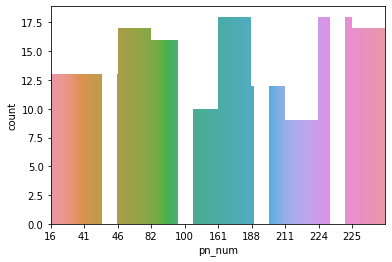

In [ ]:
print("Количество уникальных значений pn_num: {}".format(train_joined["pn_num"].nunique()))
ax = sns.countplot(x="pn_num", data=train_joined)
ax.set_xticks(np.arange(0, 1000, 100));

`pn_num` - это уникальный ID заметки со слов пациента (`pn_history`). Не все заметки присутствуют в тренировочной выборке. Всего в тренировочной выборке таких значений 1000.

In [ ]:
print(patient_notes["pn_num"].nunique())
print(train["pn_num"].nunique())

42146

1000

Смысл разбиения на фолды заключается в следующем. На 4-х фолдах выполняется training loop, а на пятом - eval loop (в случае разбиения на 5-ть фолдов). На следующей итерации происходит смена фолдов.

Группировка происходит, как было сказано, по значению колонки `pn_num`. Т.е. данные по одной заметке попадают в один фолд. При этом распределение групп по фолдам подбирается таким образом, чтобы группы были сбалансированы (имели приблизетельно одинаковое количество данных).

Пример:

In [ ]:
testset = train_joined.copy()

# добавим колонку с номером фолда
groups = testset["pn_num"].values
splitter = GroupKFold(n_splits=5)

# метод split возвращает индексы тренировочной выборки и тестовой на данном номере разбиения
for n, (_, val_indexes) in enumerate(splitter.split(testset, testset['location'], groups)):
  testset.loc[val_indexes, 'fold'] = n
testset['fold'] = testset['fold'].astype('int8')

In [ ]:
pn_num_f0 = set(testset[testset["fold"] == 0]["pn_num"].unique())
pn_num_not_f0 = set(testset[testset["fold"] != 0]["pn_num"].unique())

print("Пересечение pn_num в фолде 0 с остальными фолдами: {}".format(len(pn_num_not_f0.intersection(pn_num_f0))))

Пересечение pn_num в фолде 0 с остальными фолдами: 0


Как мы видим на примере 0-го фолда, фолды по значению `pn_num` не пересекаются.

In [ ]:
logging.basicConfig(
    level=logging.WARNING, 
    format='[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
)
LOGGER = logging.getLogger(__name__)


class TrainModel:

  def __init__(self, config_path: str = "nmbe_model/config.yaml", logging_level="INFO") -> None:
    # set logging level
    LOGGER.setLevel(logging_level)

    # load configuration
    LOGGER.info("Configuration loading...")
    config_file = read_yaml(file_path=config_path)
    self._model_cfg = ModelConfig(**config_file.get("model"))
    self._data_cfg = DataConfig(**config_file.get("data"))
    self._train_cfg = TrainConfig(**config_file.get("train"))
    LOGGER.info("Done.")

    # set device
    self._device = torch.device(self._train_cfg.device if torch.cuda.is_available() else 'cpu')

    # set model
    LOGGER.info("Model initialization...")
    self.model = self._model_initialization()
    LOGGER.info("Done.")

    # move model to cuda if available
    self.model.to(self._device)

    # loading the tokenizer
    LOGGER.info("Tokenizer loading...")
    self._tokenizer = AutoTokenizer.from_pretrained(self._model_cfg.checkpoint)
    LOGGER.info("Done.")

  def _model_initialization(self) -> nn.Module:
    return DeBertaForTokenClassification(**self._model_cfg.__dict__)

  def _cv_split(self, dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Split dataset into equal folds, stratified by patient notes and add column with number of a fold to the initial dataset.

    :param dataset:
    :type dataset: pd.DataFrame.
    :rtype dataset: pd.DataFrame
    :return dataset:
    """
    assert {'pn_num', 'location'}.issubset(set(dataset.columns)), 'The dataset must necessarily contain columns "location" and "pn_num"'
    assert self._train_cfg.n_folds > 0, 'Number of folds must be at least 1'

    if self._train_cfg.n_folds == 1:
      dataset['fold'] = 0
    else:
      splitter = GroupKFold(n_splits=self._train_cfg.n_folds)
      groups = dataset['pn_num'].values
      for n, (_, val_indexes) in enumerate(splitter.split(dataset, dataset['location'], groups)):
        dataset.loc[val_indexes, 'fold'] = n
      dataset['fold'] = dataset['fold'].astype('int8')
    return dataset
  
  def _prepare_dataloaders(self, dataset: pd.DataFrame, fold: int) -> Tuple[DataLoader, DataLoader]:
    # trainloader preparation
    train_df = dataset[dataset['fold'] != fold]
    train_df = train_df.reset_index(drop=True, inplace=False)
    trainset = CustomDataset(tokenizer=self._tokenizer, feature_texts=train_df['feature_text'].values, 
                             pn_histories=train_df['pn_history'].values, locations=train_df['location'].values,
                             max_length=self._data_cfg.max_length)
    trainloader = DataLoader(dataset=trainset, batch_size=self._train_cfg.batch_size, shuffle=True, 
                             num_workers=self._train_cfg.n_workers, pin_memory=True, drop_last=True)
    
    # evalloader preparation
    eval_df = dataset[dataset['fold'] == fold]
    eval_df = eval_df.reset_index(drop=True, inplace=False)
    evalset = CustomDataset(tokenizer=self._tokenizer, feature_texts=eval_df['feature_text'].values, 
                            pn_histories=eval_df['pn_history'].values, locations=eval_df['location'].values,
                            max_length=self._data_cfg.max_length)
    evalloader = DataLoader(dataset=evalset, batch_size=self._train_cfg.batch_size, shuffle=False, 
                            num_workers=self._train_cfg.n_workers, pin_memory=True, drop_last=False)
    return trainloader, len(train_df), evalloader

  def _get_trainable_params(self) -> List[dict]:
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    trainable_params = [
      {'params': [param for node, param in self.model.backbone.named_parameters() if not any(nd in node for nd in no_decay)], 
       'lr': self._train_cfg.backbone_lr, 'weight_decay': self._train_cfg.weight_decay}, 
      {'params': [param for node, param in self.model.backbone.named_parameters() if any(nd in node for nd in no_decay)],
       'lr': self._train_cfg.backbone_lr, 'weight_decay': 0.0},
      {'params': [param for _, param in self.model.fc.named_parameters()],
       'lr': self._train_cfg.fc_lr, 'weight_decay': 0.0}]
    return trainable_params

  def _set_configurator(self, num_training_steps: int):
    # configure optimizer
    trainable_params = self._get_trainable_params()
    optimizer = AdamW(
        params=trainable_params, lr=self._train_cfg.backbone_lr, betas=self._train_cfg.betas, eps=self._train_cfg.eps)

    # configure scheduler
    scheduler = None
    if self._train_cfg.scheduler_type == "linear":
      scheduler = get_linear_schedule_with_warmup(
          optimizer, num_warmup_steps=self._train_cfg.num_warmup_steps,
          num_training_steps=num_training_steps)
    elif self._train_cfg.scheduler_type == "cosine":
      scheduler = get_cosine_schedule_with_warmup(
          optimizer, num_warmup_steps=self._train_cfg.num_warmup_steps,
          num_training_steps=num_training_steps, num_cycles=self._train_cfg.num_cycles)
    return optimizer, scheduler

  def fit(self, dataset: pd.DataFrame, n_epochs: int = 5):
    # add fold num to the dataset
    LOGGER.info("Splitting dataset into %d fold(s)...", self._train_cfg.n_folds)
    dataset = self._cv_split(dataset=dataset)
    LOGGER.info("Done.")

    # iterate over folds
    for curr_fold in range(self._train_cfg.n_folds):
      # prepare dataloader
      trainloader, train_size, evalloader = self._prepare_dataloaders(dataset=dataset, fold=curr_fold)
      self.fit_on_fold(
          trainloader=trainloader, train_size=train_size, evalloader=evalloader, n_epochs=n_epochs)
    return

  def fit_on_fold(
      self, trainloader: DataLoader, train_size: int, evalloader: DataLoader, n_epochs: int = 5):
    # configure optimizer and scheduler
    num_training_steps = int(train_size / self._train_cfg.batch_size * n_epochs)
    optimizer, scheduler = self._set_configurator(num_training_steps=num_training_steps)
    
    for epoch in tqdm(range(n_epochs)):
      running_loss_train = self.train_loop(trainloader=trainloader)

      with torch.no_grad():
        running_loss_eval = self.eval_loop(evalloader=evalloader)
    return

  def train_loop(self, trainloader: DataLoader):
    running_loss = list()

    self.model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=)
    for step, (inputs, labels) in enumerate(trainloader):
      # relocate inputs and labels to device
      inputs = {k: v.to(self._device) for k, v in inputs.items()}
      labels = labels.to(self._device)
    return

  def eval_loop(self, evalloader: DataLoader):
    running_loss = list()
    return
    

In [ ]:
training_loop = TrainModel()

ds = train_joined.copy()
# training_loop.fit(dataset=ds)

INFO:__main__:Configuration loading...
INFO:__main__:Done.
INFO:__main__:Model initialization...
Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:__main__:Done.
INFO:__main__:Tokenizer loading...
INFO:__main__:Done.


## Tests

In [ ]:
train_cfg

TrainConfig(device='cuda', batch_size=12, n_folds=5, n_workers=4, backbone_lr=2e-05, fc_lr=2e-05, weight_decay=0.01, betas=[0.9, 0.999], eps=1e-08, scheduler_type='linear', num_warmup_steps=0, num_cycles=0.5)